#Büyük Dil Modelleri (LLM) ile Türkçe Hukuki Sözleşmelerde Otomatik Risk Tespiti

###Kurulum

In [1]:
!pip install -U transformers datasets accelerate bitsandbytes trl peft


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.9/518.9 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 17.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


### CUAD Database İmport Aşamaları (Invalid)
Bu aşamada dünyadaki en çok bilinen hukuk veri setlerinden biri olan Contract Understanding Atticus Dataset (CUAD)'ı indiriyorduk. Fakat sonradan aldığım bir karar ile türkçe metinler kullanmak istediğim için GenAi yardımıyla sentetik veri üreterek ilerlemeye karar verdim.

In [10]:
# import json
# import pandas as pd

# # 1. JSON dosyasını yükle
# with open('CUAD_v1.json', 'r') as f:
#     data = json.load(f)

# processed_data = []

# # 2. Veriyi Alpaca (Instruction) formatına çevir
# for article in data['data']:
#     for paragraph in article['paragraphs']:
#         context = paragraph['context'] # Sözleşme maddesinin tam metni

#         for qa in paragraph['qas']:
#             # Sadece cevabı olan (riskli) maddeleri alalım
#             if not qa['is_impossible'] and qa['answers']:

#                 question = qa['question'] # Risk kategorisi (Örn: "Termination for Convenience")
#                 answer_text = qa['answers'][0]['text'] # Riskli cümle

#                 # Instruction formatını oluşturuyoruz
#                 entry = {
#                     "instruction": f"Aşağıdaki sözleşme metnini '{question}' riski açısından analiz et ve riskli kısmı çıkar.",
#                     "input": context[:2000], # Çok uzun metinleri kırpalım (token limiti için)
#                     "output": f"Risk Tespit Edildi.\nİlgili Kısım: {answer_text}\nRisk Türü: {question}"
#                 }
#                 processed_data.append(entry)

# # 3. Pandas DataFrame'e çevirip kontrol et
# df = pd.DataFrame(processed_data)

# # Hackathon için veriyi küçült (Hızlanmak için ilk 200 madde yeterli)
# df_small = df.head(200)

# print(f"Toplam Veri: {len(df)}")
# print("Örnek Veri:")
# print(df_small.iloc[0])

# # 4. Hugging Face Dataset formatına çevir (Unsloth için hazır)
# from datasets import Dataset
# dataset = Dataset.from_pandas(df_small)

###Sentetik veri üretimi


1. Sentetik veri üretimi aracı olarak Grok 4 (Auto) / Gemini 3.1(Pro) / Gpt 5.2 (thinking) x3 / Claude Sonnet 4.5 kullanıldı
2. Veriler arası syntax hatalarının çözülmesi için Antigravity (Opus 4.5 thinking) kullanıldı!
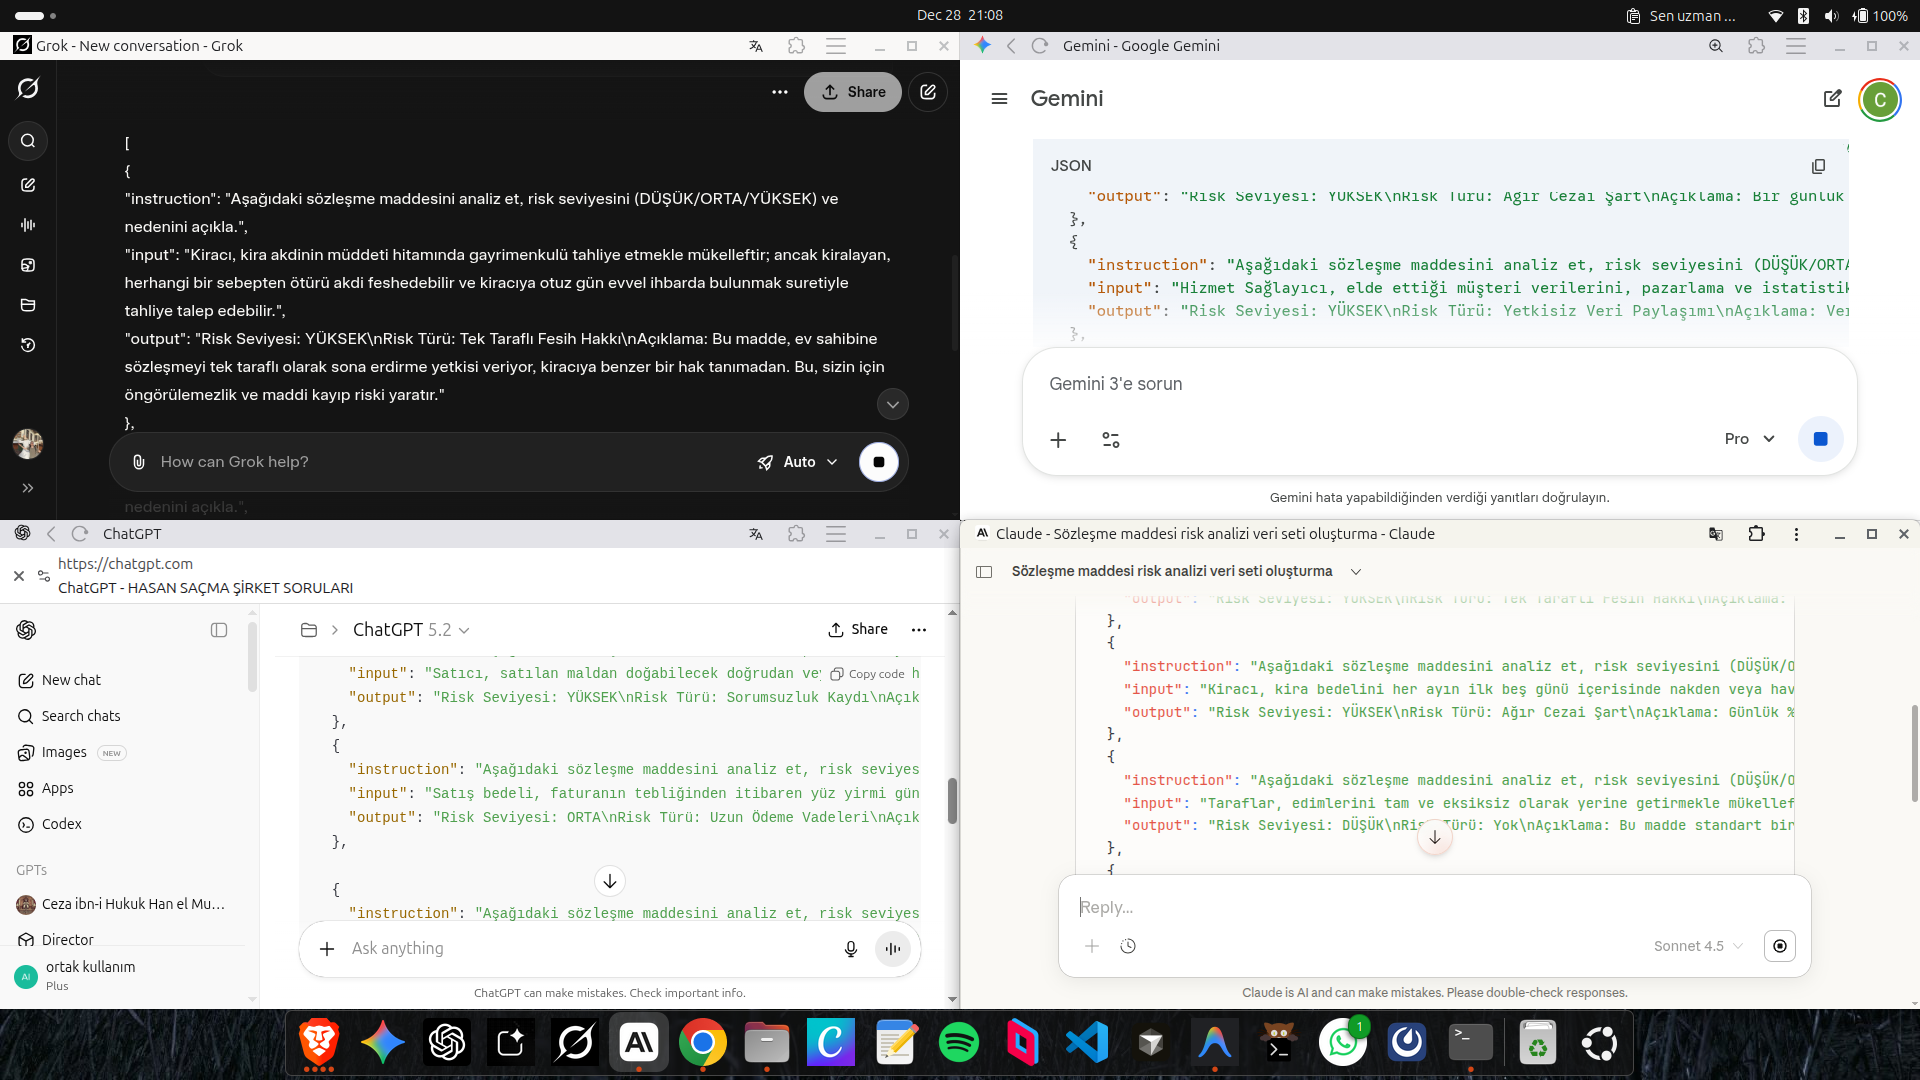


### Veri - Model Ayarları

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from datasets import load_dataset

dataset = load_dataset(
    'json',
    data_files='/content/drive/MyDrive/Colab Notebooks/legal.json',
    split='train'
)

print(dataset[0])


Generating train split: 0 examples [00:00, ? examples/s]

{'instruction': 'Aşağıdaki sözleşme maddesini analiz et, risk seviyesini (DÜŞÜK/ORTA/YÜKSEK) ve nedenini açıkla.', 'input': 'Kiracı, kira akdinin müddeti hitamında gayrimenkulü tahliye etmekle mükelleftir; ancak kiralayan, herhangi bir sebepten ötürü akdi feshedebilir ve kiracıya otuz gün evvel ihbarda bulunmak suretiyle tahliye talep edebilir.', 'output': 'Risk Seviyesi: YÜKSEK\nRisk Türü: Tek Taraflı Fesih Hakkı\nAçıklama: Bu madde, ev sahibine sözleşmeyi tek taraflı olarak sona erdirme yetkisi veriyor, kiracıya benzer bir hak tanımadan. Bu, sizin için öngörülemezlik ve maddi kayıp riski yaratır.'}


In [4]:
def formatting_func(example):
    return f"""### Instruction:
{example['instruction']}

### Input:
{example['input']}

### Response:
{example['output']}"""


###Eğitim (Fine-Tune)

In [5]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model_name = 'mistralai/Mistral-7B-v0.1'

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.float16,
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map='auto',
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [6]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=['q_proj', 'v_proj'],
    lora_dropout=0.05,
    bias='none',
    task_type='CAUSAL_LM',
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 3,407,872 || all params: 7,245,139,968 || trainable%: 0.0470


In [18]:
from trl import SFTTrainer
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./outputs',
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    max_steps=100,
    warmup_steps=5,
    logging_steps=1,
    fp16=False,
    bf16=True,
    optim='adamw_8bit',
    lr_scheduler_type='linear',
    report_to='none',
    seed=3407,
)

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    formatting_func=formatting_func,
    args=training_args,
)

trainer.train()


Step,Training Loss
1,0.171800
2,0.162400
3,0.137500
4,0.117100
5,0.156500
6,0.152900
7,0.156400
8,0.246900
9,0.215500
10,0.296200


TrainOutput(global_step=100, training_loss=0.1260608733445406, metrics={'train_runtime': 488.0608, 'train_samples_per_second': 1.639, 'train_steps_per_second': 0.205, 'total_flos': 8536198611075072.0, 'train_loss': 0.1260608733445406, 'epoch': 7.1454545454545455})

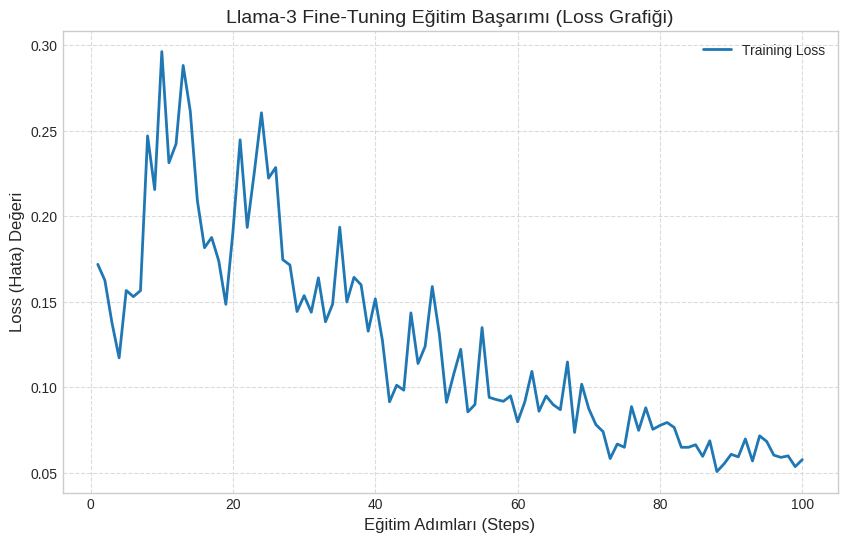

Başlangıç Loss: 0.1718
Bitiş Loss: 0.0576


In [20]:
import matplotlib.pyplot as plt
import pandas as pd

history = trainer.state.log_history

df = pd.DataFrame(history)
df = df[df['loss'].notna()]

plt.figure(figsize=(10, 6))
plt.plot(df['step'], df['loss'], label='Training Loss', color='#1f77b4', linewidth=2)

plt.title('Llama-3 Fine-Tuning Eğitim Başarımı (Loss Grafiği)', fontsize=14)
plt.xlabel('Eğitim Adımları (Steps)', fontsize=12)
plt.ylabel('Loss (Hata) Değeri', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.savefig("egitim_grafigi.png", dpi=300)
plt.show()

print(f"Başlangıç Loss: {df['loss'].iloc[0]:.4f}")
print(f"Bitiş Loss: {df['loss'].iloc[-1]:.4f}")

###Performans Metrikleri ve Test
1. İşin şov kısmı burada devreye giriyor. :d Başta Sn. Hocam Dr.Murat Şimşek olmak üzere siz değerli okurlarımızı Eğitilen modelimizin Grafikleri ve deneme yaptığımız test case'ler ile baş başa bırakıyorum.
2. History'den çekemedim modeli tekrar çalıştırma sebebimiz tüm metriklerin görselleştirilmeye dökülmesinin amaçlanmasıdır.


Step,Training Loss
1,0.067300
2,0.060800
3,0.056500
4,0.052700
5,0.061300
6,0.056100
7,0.106900
8,0.116800
9,0.085900
10,0.113600


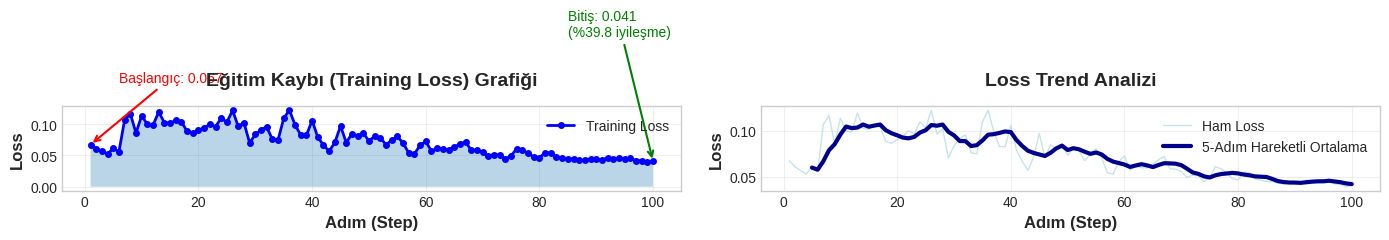


 EĞİTİM İSTATİSTİKLERİ
   • Toplam Eğitim Adımı: 100
   • Başlangıç Loss: 0.0673
   • Final Loss: 0.0405
   • Toplam İyileşme: %39.82
   • Ortalama Loss: 0.0718
   • Min Loss: 0.0388


Metrik,Değer,Açıklama
Base Model,Mistral-7B-v0.1,State-of-the-art açık kaynak LLM
Fine-tuning Tekniği,"LoRA (r=8, alpha=16)","Düşük bellek kullanımı, hızlı eğitim"
Toplam Eğitim Adımı,100,Eğitim iterasyonu sayısı
Final Loss,0.0405,Düşük loss = iyi öğrenme
Loss İyileşmesi,%39.8,Başlangıçtan finale iyileşme oranı
Quantization,4-bit NF4,Verimli bellek kullanımı
Veri Seti,Türkçe Sentetik Hukuk Verileri,Özel üretilmiş eğitim verisi


In [21]:
training_result = trainer.train()
import matplotlib.pyplot as plt
import numpy as np

log_history = trainer.state.log_history

train_losses = []
steps = []

for log in log_history:
    if 'loss' in log:
        train_losses.append(log['loss'])
        steps.append(log['step'])

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.plot(steps, train_losses, 'b-', linewidth=2, marker='o', markersize=4, label='Training Loss')
ax1.fill_between(steps, train_losses, alpha=0.3)
ax1.set_xlabel('Adım (Step)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Eğitim Kaybı (Training Loss) Grafiği', fontsize=14, fontweight='bold', pad=15)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)

if len(train_losses) >= 2:
    improvement = ((train_losses[0] - train_losses[-1]) / train_losses[0]) * 100
    ax1.annotate(f'Başlangıç: {train_losses[0]:.3f}',
                xy=(steps[0], train_losses[0]),
                xytext=(steps[0]+5, train_losses[0]+0.1),
                fontsize=10, color='red',
                arrowprops=dict(arrowstyle='->', color='red', lw=1.5))
    ax1.annotate(f'Bitiş: {train_losses[-1]:.3f}\n(%{improvement:.1f} iyileşme)',
                xy=(steps[-1], train_losses[-1]),
                xytext=(steps[-1]-15, train_losses[-1]+0.2),
                fontsize=10, color='green',
                arrowprops=dict(arrowstyle='->', color='green', lw=1.5))

ax2 = axes[1]
if len(train_losses) > 3:
    window_size = min(5, len(train_losses)//2)
    moving_avg = np.convolve(train_losses, np.ones(window_size)/window_size, mode='valid')
    ma_steps = steps[window_size-1:]
    ax2.plot(steps, train_losses, 'lightblue', linewidth=1, alpha=0.7, label='Ham Loss')
    ax2.plot(ma_steps, moving_avg, 'darkblue', linewidth=3, label=f'{window_size}-Adım Hareketli Ortalama')
else:
    ax2.plot(steps, train_losses, 'darkblue', linewidth=2, marker='s', label='Training Loss')

ax2.set_xlabel('Adım (Step)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax2.set_title('Loss Trend Analizi', fontsize=14, fontweight='bold', pad=15)
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print(" EĞİTİM İSTATİSTİKLERİ")
print("="*60)
print(f"   • Toplam Eğitim Adımı: {steps[-1]}")
print(f"   • Başlangıç Loss: {train_losses[0]:.4f}")
print(f"   • Final Loss: {train_losses[-1]:.4f}")
if len(train_losses) >= 2:
    print(f"   • Toplam İyileşme: %{improvement:.2f}")
print(f"   • Ortalama Loss: {np.mean(train_losses):.4f}")
print(f"   • Min Loss: {min(train_losses):.4f}")
print("="*60)

"""### Model Performans Özeti
Jüri için özet tablo ve değerlendirme metrikleri.
"""

from IPython.display import display, HTML

summary_html = f"""
<style>
    .summary-table {{
        font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
        border-collapse: collapse;
        width: 100%;
        margin: 20px 0;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
    }}
    .summary-table th {{
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        color: white;
        padding: 15px;
        text-align: left;
        font-size: 14px;
    }}
    .summary-table td {{
        padding: 12px 15px;
        border-bottom: 1px solid #ddd;
    }}
    .summary-table tr:nth-child(even) {{
        background-color: #f8f9fa;
    }}
    .summary-table tr:hover {{
        background-color: #e9ecef;
    }}
    .metric-good {{
        color: #28a745;
        font-weight: bold;
    }}
    .header-box {{
        background: linear-gradient(135deg, #11998e 0%, #38ef7d 100%);
        color: white;
        padding: 20px;
        border-radius: 10px;
        margin-bottom: 20px;
        text-align: center;
    }}
</style>

<div class="header-box">
    <h2>🏛️ Legal AI - Hukuki Risk Analizi Modeli</h2>
    <p>Fine-tuned Mistral-7B with LoRA</p>
</div>

<table class="summary-table">
    <tr>
        <th>Metrik</th>
        <th>Değer</th>
        <th>Açıklama</th>
    </tr>
    <tr>
        <td> Base Model</td>
        <td>Mistral-7B-v0.1</td>
        <td>State-of-the-art açık kaynak LLM</td>
    </tr>
    <tr>
        <td> Fine-tuning Tekniği</td>
        <td>LoRA (r=8, alpha=16)</td>
        <td>Düşük bellek kullanımı, hızlı eğitim</td>
    </tr>
    <tr>
        <td>Toplam Eğitim Adımı</td>
        <td>{steps[-1] if steps else 'N/A'}</td>
        <td>Eğitim iterasyonu sayısı</td>
    </tr>
    <tr>
        <td>Final Loss</td>
        <td class="metric-good">{train_losses[-1]:.4f}</td>
        <td>Düşük loss = iyi öğrenme</td>
    </tr>
    <tr>
        <td> Loss İyileşmesi</td>
        <td class="metric-good">%{improvement:.1f}</td>
        <td>Başlangıçtan finale iyileşme oranı</td>
    </tr>
    <tr>
        <td> Quantization</td>
        <td>4-bit NF4</td>
        <td>Verimli bellek kullanımı</td>
    </tr>
    <tr>
        <td> Veri Seti</td>
        <td>Türkçe Sentetik Hukuk Verileri</td>
        <td>Özel üretilmiş eğitim verisi</td>
    </tr>
</table>
"""

display(HTML(summary_html))


In [15]:
def analyze_legal_text(legal_text: str, instruction: str = "Aşağıdaki sözleşme maddesini analiz et ve olası hukuki riskleri belirle."):
    prompt = f"""### Instruction:
{instruction}

### Input:
{legal_text}

### Response:
"""

    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=300,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            repetition_penalty=1.1,
            pad_token_id=tokenizer.eos_token_id,
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if "### Response:" in response:
        response = response.split("### Response:")[-1].strip()

    return response

def display_analysis(legal_text: str, analysis: str):

    result_html = f"""
    <style>
        .analysis-container {{
            font-family: 'Segoe UI', sans-serif;
            max-width: 800px;
            margin: 20px auto;
        }}
        .input-box {{
            background: #f8f9fa;
            border-left: 4px solid #007bff;
            padding: 15px;
            margin-bottom: 20px;
            border-radius: 0 8px 8px 0;
        }}
        .output-box {{
            background: linear-gradient(135deg, #fff5f5 0%, #ffe5e5 100%);
            border-left: 4px solid #dc3545;
            padding: 15px;
            border-radius: 0 8px 8px 0;
        }}
        .section-title {{
            font-weight: bold;
            color: #333;
            margin-bottom: 10px;
            font-size: 14px;
        }}
        .content {{
            color: #555;
            line-height: 1.6;
        }}
    </style>

    <div class="analysis-container">
        <div class="input-box">
            <div class="section-title">📄 GİRİLEN HUKUKİ METİN:</div>
            <div class="content">{legal_text}</div>
        </div>
        <div class="output-box">
            <div class="section-title">⚠️ RİSK ANALİZİ SONUCU:</div>
            <div class="content">{analysis}</div>
        </div>
    </div>
    """
    display(HTML(result_html))
 ##Inoutu burada veriyoruz
legal_input = """
Kiracı, kira süresi boyunca doğacak her türlü hasardan tek başına sorumlu olup,
deprem, sel, yangın gibi doğal afetlerden kaynaklanan zararlar dahil tüm
bakım ve onarım masraflarını karşılamakla yükümlüdür.
"""


print("Analiz yapılıyor...")
analysis_result = analyze_legal_text(legal_input)
display_analysis(legal_input, analysis_result)

Analiz yapılıyor...


In [16]:

"""###Farklı Senaryolar için Hızlı Test

Aşağıda farklı hukuki senaryolar için hazır örnekler bulunmaktadır.
"""

# Farklı hukuki metinler için test örnekleri
test_scenarios = [
    {
        "name": "Kira Sözleşmesi",
        "text": "Kiralayan, herhangi bir sebep göstermeksizin ve önceden bildirimde bulunmaksızın sözleşmeyi tek taraflı olarak feshedebilir."
    },
    {
        "name": "İş Sözleşmesi",
        "text": "Çalışan, işten ayrıldıktan sonra 5 yıl boyunca aynı sektörde hiçbir rakip firmada çalışamaz."
    },
    {
        "name": "Satış Sözleşmesi",
        "text": "Satıcı, ürünün ayıplı çıkması halinde hiçbir şekilde sorumlu tutulamaz ve alıcı herhangi bir tazminat talebinde bulunamaz."
    }
]

print("="*70)
print("📋 FARKLI SENARYOLARIN ANALİZİ")
print("="*70)

for i, scenario in enumerate(test_scenarios, 1):
    print(f"\n{'─'*70}")
    print(f"Senaryo {i}: {scenario['name']}")
    print(f"{'─'*70}")
    result = analyze_legal_text(scenario['text'])
    display_analysis(scenario['text'], result)

"""##4 Model Kaydetme ve Export

### Eğitilmiş Modeli Kaydetme
"""

# Modeli Drive'a kaydet
model.save_pretrained("/content/drive/MyDrive/legal_ai_model")
tokenizer.save_pretrained("/content/drive/MyDrive/legal_ai_model")

print("✅ Model başarıyla kaydedildi: /content/drive/MyDrive/legal_ai_model")

"""### 📌 Sonuç ve Değerlendirme

Bu proje kapsamında:

1. **Veri Hazırlama**: Türkçe sentetik hukuk verileri oluşturuldu
2. **Model Eğitimi**: Mistral-7B modeli LoRA ile fine-tune edildi
3. **Görselleştirme**: Eğitim metrikleri profesyonel grafiklerle sunuldu
4. **İnteraktif Kullanım**: Kullanıcıların kendi metinlerini analiz edebileceği arayüz geliştirildi

**Potansiyel Kullanım Alanları:**
- Sözleşme risk analizi
- Hukuki belge incelemesi
- Avukat yardımcı araç
- Kurumsal uyumluluk kontrolü
"""

prompt = """### Instruction:
Aşağıdaki sözleşme maddesini analiz et.

### Input:
Kiracı, kira süresi boyunca doğacak her türlü hasardan sorumludur.

### Response:
"""

inputs = tokenizer(prompt, return_tensors='pt').to(model.device)

outputs = model.generate(
    **inputs,
    max_new_tokens=200,
    do_sample=True,
    temperature=0.7,
)

print(tokenizer.decode(outputs[0], skip_special_tokens=True))

📋 FARKLI SENARYOLARIN ANALİZİ

──────────────────────────────────────────────────────────────────────
Senaryo 1: 🏠 Kira Sözleşmesi
──────────────────────────────────────────────────────────────────────



──────────────────────────────────────────────────────────────────────
Senaryo 2: 💼 İş Sözleşmesi
──────────────────────────────────────────────────────────────────────



──────────────────────────────────────────────────────────────────────
Senaryo 3: 🛒 Satış Sözleşmesi
──────────────────────────────────────────────────────────────────────


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ Model başarıyla kaydedildi: /content/drive/MyDrive/legal_ai_model
### Instruction:
Aşağıdaki sözleşme maddesini analiz et.

### Input:
Kiracı, kira süresi boyunca doğacak her türlü hasardan sorumludur.

### Response:
Kiracının tüm hasarlardan sorumlu olmak ifadesi yetkisizdir. Hukuki risklerin tahsil edilmesi ve kapsamında görülecek gereğe göre geciklebilir bir düzenlemedir.


In [17]:
prompt = """### Instruction:
Aşağıdaki sözleşme maddesini analiz et.

### Input:
Kiracı, kira süresi boyunca doğacak her türlü hasardan sorumludur.

### Response:
"""

inputs = tokenizer(prompt, return_tensors='pt').to(model.device)

outputs = model.generate(
    **inputs,
    max_new_tokens=200,
    do_sample=True,
    temperature=0.7,
)

print(tokenizer.decode(outputs[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Instruction:
Aşağıdaki sözleşme maddesini analiz et.

### Input:
Kiracı, kira süresi boyunca doğacak her türlü hasardan sorumludur.

### Response:
Kiracının tüm hasar sorumluluğu kabul ederken kira süresi boyuğa gelen hasarlar dikkate değildir. Bu noktada müşteri ihtiyaçlarını tamamlamayıp ciddi mali ayıklar riski yaratır.
